<a href="https://colab.research.google.com/github/HazemAbdo/FloodSense/blob/classification%2Fmachine_learning/SI_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resources:
* https://arxiv.org/pdf/1909.00125.pdf
* https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01
* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

# Imports

In [75]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
#--------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
#--------------------------------------------------
from skimage.filters import gabor_kernel
from skimage import io, color
from skimage.feature import hog,local_binary_pattern,sift
from scipy import ndimage as ndi
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.feature import ORB, match_descriptors
#--------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [4]:
!pip install opencv-python-headless
!pip install tqdm
#tqdm is a Python package that provides a progress bar for iterative tasks
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helpers

In [6]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [7]:
def extract_file(zip_path,specified_directory):
  # create a ZipFile object
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  # extract all contents to a specified directory
    zip_ref.extractall(specified_directory)


In [8]:
def read_images_gray( flooded_path,non_flooded_path,image_size):
    flooded = np.empty((0, image_size, image_size))
    non_flooded = np.empty((0, image_size, image_size))
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0  # normalize pixel values to the range of [0, 1]
        img = np.expand_dims(img, axis=0) # add an extra dimension for concatenation
        flooded = np.concatenate((flooded, img), axis=0)

   
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded


In [9]:
def read_images_rgb( flooded_path,non_flooded_path,image_size):
    flooded = np.empty((0, image_size, image_size, 3))
    non_flooded = np.empty((0, image_size, image_size, 3))

    
    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0) 
        flooded = np.concatenate((flooded, img), axis=0)

   
    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (image_size, image_size)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [10]:
def show_images(images,images_labels,is_gray=True):
  if is_gray:
    Cmap='gray'
  else:
    Cmap=None
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic,cmap=Cmap)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

In [11]:
def evaluate(y_train,y_train_pred,y_test,y_test_pred,model_name):
    print(f"Model: {model_name}")
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    cr_train = classification_report(y_train, y_train_pred,zero_division=1.0)
    cr_test = classification_report(y_test, y_test_pred,zero_division=1.0)
    fn_train = cm_train[1][0]
    fn_test = cm_test[1][0]
    pos_train = cm_train[1][0] + cm_train[1][1]
    pos_test = cm_test[1][0] + cm_test[1][1]
    omission_error_train = fn_train / pos_train
    omission_error_test = fn_test / pos_test
    fp_train = cm_train[0][1]
    fp_test = cm_test[0][1]
    neg_train = cm_train[0][0] + cm_train[0][1]
    neg_test = cm_test[0][0] + cm_test[0][1]
    commission_error_train = fp_train / neg_train
    commission_error_test = fp_test / neg_test
    print("Train")
    print(cm_train)
    print(cr_train)
    print("Omission error rate:", omission_error_train)
    print("Commission error rate:", commission_error_train)
    print("Test")
    print(cm_test)
    print(cr_test)
    print("Omission error rate:", omission_error_test)
    print("Commission error rate:", commission_error_test)
    

# Images reading 

In [12]:
extract_file("drive/MyDrive/Copy of dataset.zip","/content")

In [13]:
flooded,non_flooded=read_images_rgb("dataset/flooded","dataset/non-flooded",224)
print("flooded images shapes",flooded.shape)
print("non_flooded images shapes",non_flooded.shape)

flooded images shapes (461, 224, 224, 3)
non_flooded images shapes (461, 224, 224, 3)


In [14]:
def split_data(flooded,non_flooded,shuffle=False,stratify=False):
  '''
  split data into train and test 
  '''
  stratify_1=None
  X = np.concatenate((flooded, non_flooded), axis=0)
  y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)
  if stratify:
    stratify_1=y
  # 80% training , 20% testing
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=shuffle,stratify=stratify_1,random_state=42)
  return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test=split_data(flooded,non_flooded,shuffle=True,stratify=True)
print(X_train.shape, y_train.shape) 
print(X_test.shape, y_test.shape)  

(737, 224, 224, 3) (737,)
(185, 224, 224, 3) (185,)


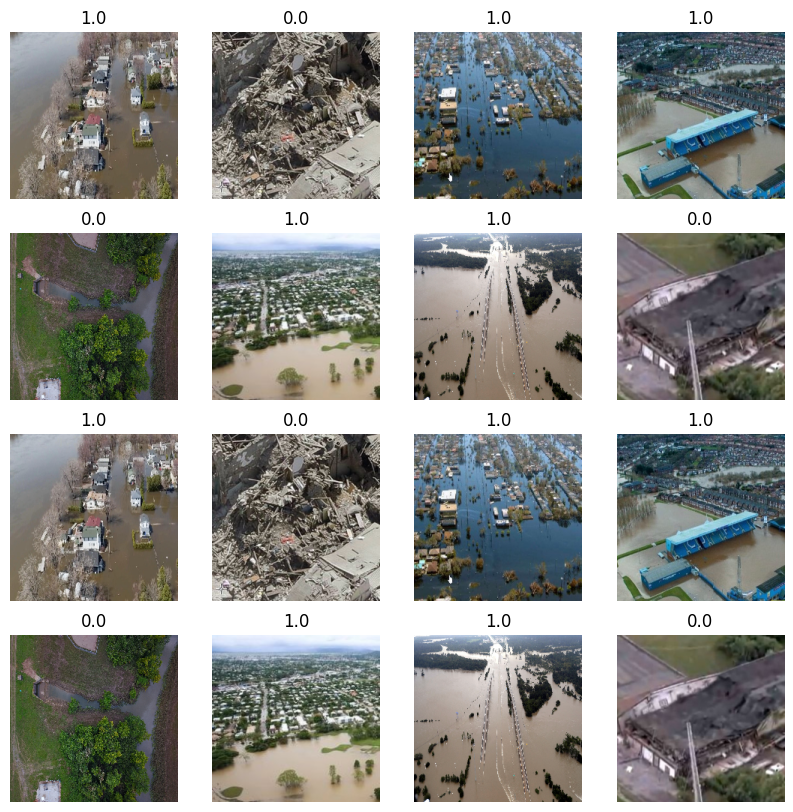

In [16]:
show_images(X_train,y_train,is_gray=False)

# Machine-learning approach

* Traditional machine learning models, such as logistic regression, SVM, or decision trees, can have high overfitting problems in image classification tasks because they lack the ability to learn complex hierarchical representations of the image data. These models typically use hand-crafted features, such as color histograms or texture descriptors, as input to the model. These features are often designed to capture specific characteristics of the image data, but may not be sufficient to capture all the relevant information needed for accurate classification.

## Feature Extraction

In [96]:
def hog_func(data_color):
    hog_features = []
    for image in data_color:
        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        hog_features.append(fd)
    hog_features = np.array(hog_features)
    return hog_features

In [97]:
# train_features = np.concatenate((hog_func(X_train),lbp_func(X_train),sift_func(X_train)),axis=1)
# test_features = np.concatenate((hog_func(X_test),lbp_func(X_test),sift_func(X_test)),axis=1)
train_features = hog_func(X_train)
test_features =  hog_func(X_test)

In [98]:
print(train_features.shape)

(737, 1568)


## Models

In [22]:
flatten_X_train = X_train.reshape(X_train.shape[0], -1)
flatten_X_test = X_test.reshape(X_test.shape[0], -1)

In [ ]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(flatten_X_train)
X_test_pca = pca.transform(flatten_X_test)

In [91]:
print(X_train_pca.shape)

(737, 443)


In [99]:
pca = PCA(n_components=0.95)
train_features_pca = pca.fit_transform(train_features)
test_features_pca = pca.transform(test_features)

In [102]:
print(train_features_pca.shape)

(737, 390)


### 2-layer neural network

In [123]:
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_dim=443),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pca, y_train, epochs=10, batch_size=32, validation_data=(X_test_pca, y_test), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 1s 10ms/step - loss: 3.4609 - accuracy: 0.5645 - val_loss: 2.0860 - val_accuracy: 0.6378
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 2.9959 - accuracy: 0.6038 - val_loss: 1.9251 - val_accuracy: 0.6865
Epoch 3/10
24/24 [==============================] - 0s 4ms/step - loss: 2.7113 - accuracy: 0.6608 - val_loss: 1.8341 - val_accuracy: 0.6703
Epoch 4/10
24/24 [==============================] - 0s 3ms/step - loss: 2.4618 - accuracy: 0.6676 - val_loss: 1.7341 - val_accuracy: 0.6919
Epoch 5/10
24/24 [==============================] - 0s 4ms/step - loss: 2.1870 - accuracy: 0.6703 - val_loss: 1.6642 - val_accuracy: 0.7135
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 1.8432 - accuracy: 0.7246 - val_loss: 1.6162 - val_accuracy: 0.7189
Epoch 7/10
24/24 [==============================] - 0s 4ms/step - loss: 1.6734 - accuracy: 0.7666 - val_loss: 1.5817 - val_accuracy: 0.7189
Epoch 8/10
24/24 [=

6/6 [==============================] - 0s 2ms/step - loss: 1.4774 - accuracy: 0.7405
2-layer neural network accuracy: 0.74


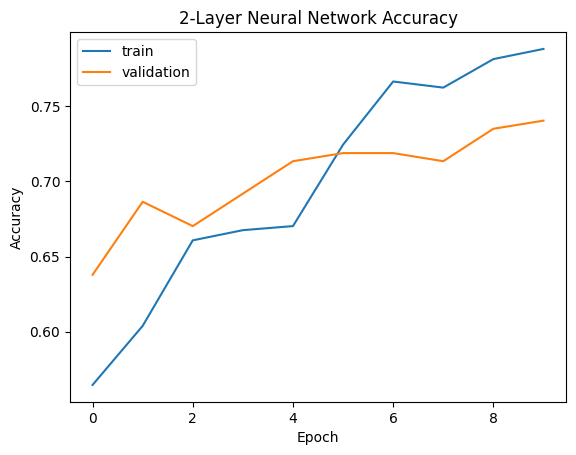

In [124]:
_, accuracy = model.evaluate(X_test_pca, y_test)
print(f"2-layer neural network accuracy: {accuracy:.2f}")

# Plot the training and validation accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2-Layer Neural Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [125]:
y_test_pred = model.predict(X_test_pca)
y_test_pred = y_test_pred.round()
cr=classification_report(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
fn = cm[1][0]
pos = cm[1][0] + cm[1][1]
omission_error = fn / pos
fp = cm[0][1]
neg = cm[0][0] + cm[0][1]
commission_error = fp / neg
print("Confusion matrix:")
print(cm)
print(cr)
print("Omission error rate:", omission_error)
print("Commission error rate:", commission_error)

6/6 [==============================] - 0s 3ms/step
Confusion matrix:
[[66 27]
 [21 71]]
              precision    recall  f1-score   support

         0.0       0.76      0.71      0.73        93
         1.0       0.72      0.77      0.75        92

    accuracy                           0.74       185
   macro avg       0.74      0.74      0.74       185
weighted avg       0.74      0.74      0.74       185

Omission error rate: 0.22826086956521738
Commission error rate: 0.2903225806451613


In [126]:
# Define a 2-layer neural network model with L2 regularization and dropout
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_dim=390),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model on the image data
history = model.fit(train_features_pca, y_train, epochs=10, batch_size=32, validation_data=(test_features_pca, y_test), callbacks=[early_stopping])

Epoch 1/10
24/24 [==============================] - 1s 10ms/step - loss: 1.6318 - accuracy: 0.5075 - val_loss: 1.4140 - val_accuracy: 0.6486
Epoch 2/10
24/24 [==============================] - 0s 4ms/step - loss: 1.2772 - accuracy: 0.6526 - val_loss: 1.1556 - val_accuracy: 0.7243
Epoch 3/10
24/24 [==============================] - 0s 5ms/step - loss: 1.0538 - accuracy: 0.7191 - val_loss: 0.9878 - val_accuracy: 0.7297
Epoch 4/10
24/24 [==============================] - 0s 4ms/step - loss: 0.9097 - accuracy: 0.7775 - val_loss: 0.8799 - val_accuracy: 0.7459
Epoch 5/10
24/24 [==============================] - 0s 3ms/step - loss: 0.8185 - accuracy: 0.7856 - val_loss: 0.8074 - val_accuracy: 0.7459
Epoch 6/10
24/24 [==============================] - 0s 4ms/step - loss: 0.7509 - accuracy: 0.7910 - val_loss: 0.7508 - val_accuracy: 0.7622
Epoch 7/10
24/24 [==============================] - 0s 3ms/step - loss: 0.6999 - accuracy: 0.8033 - val_loss: 0.7094 - val_accuracy: 0.7676
Epoch 8/10
24/24 [=

6/6 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.7730
2-layer neural network accuracy: 0.77


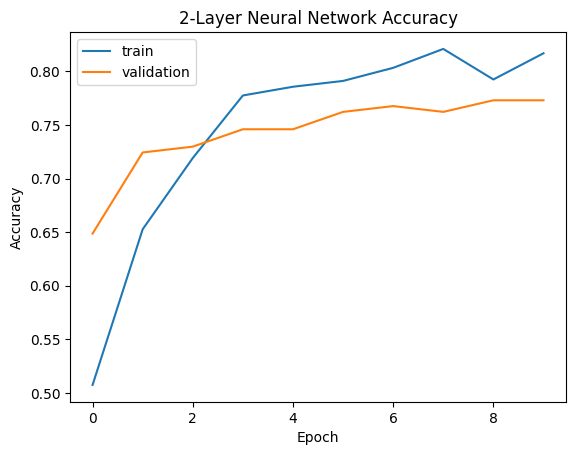

In [127]:
# Evaluate the model performance on the test data
_, accuracy = model.evaluate(test_features_pca, y_test)
print(f"2-layer neural network accuracy: {accuracy:.2f}")

# Plot the training and validation accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2-Layer Neural Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [128]:
y_test_pred = model.predict(test_features_pca)
y_test_pred = y_test_pred.round()
cr=classification_report(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)
fn = cm[1][0]
pos = cm[1][0] + cm[1][1]
omission_error = fn / pos
fp = cm[0][1]
neg = cm[0][0] + cm[0][1]
commission_error = fp / neg
print("Confusion matrix:")
print(cm)
print(cr)
print("Omission error rate:", omission_error)
print("Commission error rate:", commission_error)

6/6 [==============================] - 0s 2ms/step
Confusion matrix:
[[76 17]
 [25 67]]
              precision    recall  f1-score   support

         0.0       0.75      0.82      0.78        93
         1.0       0.80      0.73      0.76        92

    accuracy                           0.77       185
   macro avg       0.78      0.77      0.77       185
weighted avg       0.77      0.77      0.77       185

Omission error rate: 0.2717391304347826
Commission error rate: 0.1827956989247312


### Random forest

In [72]:
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('rfc', RandomForestClassifier(max_depth=5, n_estimators=200, min_samples_leaf=5))
])

# Fit the pipeline to the training data
pipe.fit(flatten_X_train, y_train)

# Make predictions on the training and testing data
y_train_pred = pipe.predict(flatten_X_train)
y_test_pred = pipe.predict(flatten_X_test)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'Random Forest on row data')

Model: Random Forest on row data
Train
[[367   1]
 [  7 362]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       368
         1.0       1.00      0.98      0.99       369

    accuracy                           0.99       737
   macro avg       0.99      0.99      0.99       737
weighted avg       0.99      0.99      0.99       737

Omission error rate: 0.018970189701897018
Commission error rate: 0.002717391304347826
Test
[[61 32]
 [18 74]]
              precision    recall  f1-score   support

         0.0       0.77      0.66      0.71        93
         1.0       0.70      0.80      0.75        92

    accuracy                           0.73       185
   macro avg       0.74      0.73      0.73       185
weighted avg       0.74      0.73      0.73       185

Omission error rate: 0.1956521739130435
Commission error rate: 0.34408602150537637


In [ ]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=100)
rfc.fit(train_features, y_train)
y_train_pred=rfc.predict(train_features)
y_test_pred=rfc.predict(test_features)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'Random Forest on extracted features')

### SVM

In [ ]:
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
svm.fit(flatten_X_train, y_train)
y_train_pred=svm.predict(flatten_X_train)
y_test_pred=svm.predict(flatten_X_test)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'SVM on row data')

In [ ]:
pca = PCA(n_components=600)
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
pipeline = Pipeline([('pca', pca), ('svm', svm)])
pipeline.fit(flatten_X_train, y_train)
y_train_pred=pipeline.predict(flatten_X_train)
y_test_pred=pipeline.predict(flatten_X_test)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'SVM with PCA on row data')

In [ ]:
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
svm.fit(train_features, y_train)
y_train_pred=svm.predict(train_features)
y_test_pred=svm.predict(test_features)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'SVM on extracted features')

In [ ]:
pca = PCA(n_components=600)
svm = SVC(C=10, gamma=0.0001, kernel='rbf')
pipeline = Pipeline([('pca', pca), ('svm', svm)])
pipeline.fit(train_features, y_train)
y_train_pred=pipeline.predict(train_features)
y_test_pred=pipeline.predict(test_features)
evaluate(y_train,y_train_pred,y_test,y_test_pred,'SVM with PCA on extracted features')